In [1]:
import warnings
import pandas as pd
import numpy as np
import re

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./data/gsmarena_product_data_final_text1.csv')
df.head()

,brand,phone_name,text
0,huawei,nova 11 SE,Network Technology GSM / CDMA / HSPA / CDMA200...
1,huawei,Mate 60 Pro+,Network Technology GSM / CDMA / HSPA / CDMA200...
2,huawei,Mate X5,Network Technology GSM / CDMA / HSPA / EVDO / ...
3,huawei,Mate 60 Pro,Network Technology GSM / CDMA / HSPA / CDMA200...
4,huawei,nova Y91,Network Technology GSM / HSPA / LTE 2G bands G...


In [3]:
df.shape

(3019, 3)

In [4]:
df['text'] = df['text'].str.lower()

In [5]:
def get_network(string):
    res = re.search(r"network.*2g bands", string)
    if res is not None:
        network = re.sub(r"network technology|2g bands|\/|gsm", "", res.group()).strip()
        if ("lte" in network) or "5g" in network or "4g" in network:
            network = re.sub(r"cdma|hspa|cdma|cdma2000|evdo|2000|umts", "", network).strip()
            # print(network)
            return network
        else:
            # print("0")
            return "0"
    else:
        # print("0")
        return "0"

In [6]:
df['network'] = df['text'].apply(lambda x: get_network(x))

In [7]:
df[df['network'] == "0"].shape

(1200, 4)

In [8]:
drop_idx = df[df['network'] == "0"].index
df = df.drop(index=drop_idx)
df.shape

(1819, 4)

In [9]:
df['text'][0]

'network technology gsm / cdma / hspa / cdma2000 / lte 2g bands gsm 850 / 900 / 1800 / 1900 - sim 1 & sim 2 cdma 800 3g bands hsdpa 850 / 900 / 1700(aws) / 1900 / 2100 cdma2000 1x 4g bands 1, 3, 4, 5, 8, 18, 19, 26, 34, 38, 39, 40, 41 speed hspa, lte-a launch announced 2023, october 31 status available. released 2023, november 03 body dimensions 162.4 x 75.5 x 7.4 mm (6.39 x 2.97 x 0.29 in) weight 186 g (6.56 oz) sim dual sim (nano-sim, dual stand-by) display type oled, 1b colors, 90hz size 6.67 inches, 107.4 cm2 (~87.6% screen-to-body ratio) resolution 1080 x 2400 pixels, 20:9 ratio (~395 ppi density) platform os harmonyos 4.0 chipset qualcomm snapdragon 680 4g (6 nm) cpu octa-core (4x2.4 ghz cortex-a73 & 4x1.9 ghz cortex-a53) gpu adreno 610 memory card slot no internal 256gb, 512gb main camera triple 108 mp, f/1.9, (wide), 1/1.67", 0.64µm, pdaf\r\n8 mp, f/2.2, 112˚ (ultrawide)\r\n2 mp, f/2.4, (macro) features led flash, hdr, panorama video 1080p@30fps selfie camera single 32 mp, f/2.

In [10]:
def get_4g_bands(text):
    pattern = re.compile(r"4g bands.*speed|4g bands.*5g")
    bands_4g = re.search(pattern, text)
    if bands_4g is not None:
        bands = re.sub(r"4g bands|speed|5g bands.*|", "", bands_4g.group()).strip()
        if "lte" not in bands:
            bands = re.findall(r"\d,|\d\d,", bands)
            if len(bands) not in [0, 1]:
                bands = " ".join(bands)
                bands = re.sub(",", "", bands)
                bands = " ".join([str(x) for x in sorted(([int(x) for x in set(bands.split())]))])
                # print(bands)
                return bands
            else:
                # print("1")
                return "1"
        else:
            # print("1")
            return "1"

In [11]:
df['4g_bands'] = df['text'].apply(lambda x: get_4g_bands(x))

In [12]:
def get_bands_count(text):
    if text not in ["1", "0"]:
        band_count = len(text.split())
        # print(band_count)
        return band_count
    elif text == "1":
        # print(1)
        return 1
    else:
        return 0

In [13]:
df['4g_band_count'] = df['4g_bands'].apply(lambda x: get_bands_count(x))

In [14]:
def get_5g_bands(text):
    res = re.search(r"5g bands.*speed|5g bands.*announced", text)
    if res is not None:
        bands = re.sub("5g bands|speed", "", res.group()).strip()
        bands = re.sub(r"sa/nsa|sa/nsa/sub6", "1,", bands).strip()
        bands = re.findall(r"\d,|\d\d,|\d\d\d,", bands)
        if len(bands) not in [0, 1]:
            bands = " ".join(bands)
            bands = re.sub(",", "", bands)
            bands = " ".join([str(x) for x in sorted(([int(x) for x in set(bands.split())]))])
            # print(bands)
            return bands
        else:
            # print("1")
            return "1"
    else:
        # print("0")
        return "0"

In [15]:
df['5g_bands'] = df['text'].apply(lambda x: get_5g_bands(x))

In [16]:
df['5g_band_count'] = df['5g_bands'].apply(lambda x: get_bands_count(x))

In [17]:
def get_released_year(text):
    pattern = re.compile(r"status.*dimensions")
    res = re.search(pattern=pattern, string=text)
    if res is not None:
        res = re.sub(r",|status|dimensions|available. released|body", "", res.group()).strip()
        if res not in ["discontinued", "cancelled"]:
            # print(res.split()[0])
            return res.split()[0]
        else:
            # print(res)
            return res
    else:
        # print('0')
        return "no info"

In [18]:
df['released_year'] = df['text'].apply(lambda x: get_released_year(x))

In [19]:
def get_full_dimension(string):
    pattern = re.compile(r"dimensions.*weight")
    res = re.search(pattern=pattern, string=string).group()
    if res is not None:
        res = re.sub(r"dimensions|weight|mm.*|unfolded|or.*|cc|\(.*|-.*|:|x", "", res).strip()
        if len(res.split()) == 3:
            # print(res)
            return " ".join(res.split())
        else:
            # print("0 x 0 x 0")
            return "0 0 0"
    else:
        # print("0 x 0 x 0")
        return "0 0 0"

In [20]:
df['height_width_depth'] = df['text'].apply(lambda x: get_full_dimension(x))

In [21]:
def get_hwd(text):
    res = [0.0, 0.0, 0.0] if text == "0 0 0" else [round(float(x), 1) for x in text.split()]
    return pd.Series(res, index=['height', 'width', 'depth'])

In [22]:
df[['height', 'width', 'depth']] = df['height_width_depth'].apply(lambda x: get_hwd(x))

In [23]:
def get_weight(string):
    res = re.search(r"weight.*sim|weight.*build", string)
    if res is not None:
        weight = re.search(r"\d\d\d g|\d\d g", res.group())
        if weight is not None:
            weight = re.sub(r"g", "", weight.group()).strip()
            return weight
        else:
            # print("0")
            return "0"
    else:
        # print("0")
        return "0"

In [24]:
df['weight'] = df['text'].apply(lambda x: get_weight(x))

In [25]:
def get_resolution(string):
    res = re.search(r"resolution.*protection|resolution.*os", string)
    if res is not None:
        resolution = re.search(r"resolution.*pixels", res.group())
        ppi = re.search(r"\(~.* ppi", res.group())
        if resolution and ppi is not None:
            resolution = " ".join(re.sub(r",.*|\(.*|pixels.*|resolution|:|x", "", resolution.group()).strip().split())
            ppi = re.sub(r"\(~|ppi", "", ppi.group()).strip()
            # print([resolution, ppi])
            return pd.Series([resolution, ppi], index=['resolution', 'ppi'])
        else:
            # print(["0 0", "0 ppi"])
            return pd.Series(["0 0", "0"], index=['resolution', 'ppi'])
    else:
        # print(["0 0", "0 ppi"])
        return pd.Series(["0 0", "0"], index=['resolution', 'ppi'])

In [26]:
df[['resolution', 'ppi']] = df['text'].apply(lambda x: get_resolution(x))

In [27]:
def get_resolution_wh(resolution):
    res = resolution.split()
    return pd.Series([float(res[0]), float(res[1])], index=['display_width', 'display_height'])

In [28]:
df[['display_width', 'display_height']] = df['resolution'].apply(lambda x: get_resolution_wh(x))

In [29]:
def get_ppi(ppi):
    res = ppi
    return float(res)

In [30]:
df['display_ppi'] = df['ppi'].apply(lambda x: get_ppi(x))

In [31]:
def display_size_str(string):
    res = re.search(r"size.*inches,", string)
    if res is not None:
        res = re.sub(r"size|inches,.*", "", res.group()).strip()
        res = str(round(float(res), 1))
        # print(res)
        return res
    else:
        # print("0")
        return "0"

In [32]:
df['display_size_str'] = df['text'].apply(lambda x: display_size_str(x))

In [33]:
def display_size(string):
    res = re.search(r"size.*inches,", string)
    if res is not None:
        res = re.sub(r"size|inches,.*", "", res.group()).strip()
        res = round(float(res), 1)
        # print(res)
        return res
    else:
        # print("0")
        return 0

In [34]:
df['display_size'] = df['text'].apply(lambda x: display_size(x))

In [35]:
def display_type(text):
    res = re.search(r"display type.*size", text)
    if res is not None:
        display_type = re.sub(
            r"display type|size|,|\(|\)|2x|international.*|hdr10|\+|ical|plus|hdr|[0-9bk]{2,4} colors|flexible|dynamic|foldable|[0-9]{3,4} nits|dolby vision|typ|hbm|peak",
            "",
            res.group(),
        ).strip()
        display_type = re.sub(r"amoled", "oled", display_type).strip()
        display_type = " ".join(display_type.split())
        # print(display_type)
        return display_type
    else:
        # print("no info")
        return "no info"

In [36]:
df['display_type'] = df['text'].apply(lambda x: display_type(x))

In [37]:
def get_os(text):
    res = re.search(r"os.*chipset", text)
    if res is not None:
        platform = re.sub(r"os|chipset|oreo|pie|or.*|,.*|\(.*|\/.*", "", res.group()).strip()
        if platform.split()[0] in ["5433)hspa", "t"]:
            platform = re.sub(r"5433\)hspa 42\.2\/5\.76 mbps|t.*", "0", platform)
        # platform = re.sub(r"5433)hspa 42.2/5.76 mbps", "0", platform).strip()
        # print(platform)
        return "".join(platform.split())
    else:
        # print("0")
        return "0"

In [38]:
df['os'] = df['text'].apply(lambda x: get_os(x))

In [39]:
def get_chipset(text):
    res = re.search(r"chipset.*", text)
    if res is not None:
        chipset = re.search(
            r"kirin [0-9a-z]{2,5}|snapdragon [0-9+gens ]{2,8}|dimensity [0-9]{2,5}|exynos [0-9]{2,4}|helio [0-9pgax]{1,4}",
            res.group(),
        )
        if chipset is not None:
            chipset = re.sub(r" 5g| 4g", "", chipset.group())
            # print(chipset)
            return "".join(chipset.split())
        else:
            # print("0")
            return "0"
    else:
        # print("0")
        return "0"

In [40]:
df['chipset'] = df['text'].apply(lambda x: get_chipset(x))

In [41]:
def get_memory(text):
    res = re.search(r"memory.*main camera", text)
    if res is not None:
        memory = re.sub(
            r"memory card slot no|memory card slot nm|main camera|umcp|\(at&t, t-mobile\)|\([0-9.]{1,3}gb user available\),|",
            "",
            res.group(),
        ).strip()
        memory_stg = re.search(r"internal.*", memory)
        if memory_stg is not None:
            memory_stg = re.sub(r"internal", "", memory_stg.group()).strip()
            memory_ram = re.findall(r"\dgb ram|\d\dgb ram", memory_stg)
            memory_stg = " ".join(re.sub(r"\dgb ram|\d\dgb ram|,", "", memory_stg).strip().split())
            if len(memory_ram) != 0:
                memory_ram = [re.sub("ram", "", "".join(x.split())) for x in memory_ram]
                memory_ram = " ".join(sorted(set(memory_ram)))
                # print(memory_ram, memory_stg)
                return pd.Series([memory_ram, memory_stg], index=['ram', 'storage'])
            else:
                # print("0")
                return pd.Series(["0", "0"], index=['ram', 'storage'])

        else:
            # print("0")
            return pd.Series(["0", "0"], index=['ram', 'storage'])
    else:
        # print('0')
        return pd.Series(["0", "0"], index=['ram', 'storage'])

In [42]:
df[['ram', 'storage']] = df['text'].apply(lambda x: get_memory(x))

In [43]:
def get_main_camera(text):
    res = re.search(r"main camera.*", text)
    if res is not None:
        main_camera = re.sub(
            r"main camera|selfie.*|,|\/|\(|\)|\"|triple|dual|single|feature|video|quad", "", res.group()
        ).strip()
        main_camera = re.search(r"|\d mp|\d\d mp|\d\d\d mp", main_camera)
        if main_camera is not None:
            # print(main_camera.group())
            return "".join(main_camera.group().strip().split())
        else:
            # print("0")
            return "0"
    else:
        # print('0')
        return '0'

In [44]:
df['main_camera'] = df['text'].apply(lambda x: get_main_camera(x))

In [45]:
def get_selfie_camera(text):
    res = re.search(r"selfie camera.*", text)
    if res is not None:
        selfie_camera = " ".join(
            re.sub(r"sound.*|selfie camera|single|dual|\/|\(|\)|\"|,|-|video", "", res.group()).strip().split()
        )
        selfie_camera = re.search(r"\d mp|\d\d mp|\d\d\d mp", selfie_camera)
        if selfie_camera is not None:
            # print(selfie_camera.group())
            return "".join(selfie_camera.group().strip().split())
        else:
            # print("0")
            return "0"
    else:
        # print("0")
        return "0"

In [46]:
df['selfie_camera'] = df['text'].apply(lambda x: get_selfie_camera(x))

In [47]:
def get_comms(text):
    res = re.search(r"comms.*", text)
    if res is not None:
        comms = re.sub(r"positioning.*|,|dual-band|comms|wlan|wi-fi|wi-fi direct|a2dp|le", "", res.group()).strip()
        bluetooth = re.search(r"bluetooth [0-9.yesno]{1,4}", comms)
        if bluetooth is not None:
            # print(bluetooth.group())
            return "".join(bluetooth.group().strip().split())
        else:
            # print("0")
            return "0"
    else:
        # print('0')
        return '0'

In [48]:
df['bluetooth'] = df['text'].apply(lambda x: get_comms(x))

In [49]:
def get_battery(text):
    battery_mah = re.search(r"\d\d\d\d mah", text)
    if battery_mah is not None:
        # print(battery_mah.group())
        return "".join(battery_mah.group().strip().split())
    else:
        # print("0")
        return "0"

In [50]:
df['battery'] = df['text'].apply(lambda x: get_battery(x))

In [51]:
df.select_dtypes(include='object').columns

Index(['brand', 'phone_name', 'text', 'network', '4g_bands', '5g_bands',
       'released_year', 'height_width_depth', 'weight', 'resolution', 'ppi',
       'display_size_str', 'display_type', 'os', 'chipset', 'ram', 'storage',
       'main_camera', 'selfie_camera', 'bluetooth', 'battery'],
      dtype='object')

In [52]:
df1 = df[
    [
        'brand',
        'released_year',
        'network',
        'display_size_str',
        'display_type',
        'os',
        'chipset',
        'ram',
        'storage',
        'main_camera',
        'selfie_camera',
        'bluetooth',
        'battery',
    ]
]

In [53]:
df1['new_text'] = df1.apply(lambda row: " ".join(map(str, row)), axis=1)

In [54]:
def remove_extra_space(text):
    res = " ".join(text.split())
    return res

In [55]:
df1['new_text'] = df1['new_text'].apply(lambda x: remove_extra_space(x))

In [77]:
df1['new_text'][1130]

'oppo 2019 lte 6.5 oled android9.0 heliop70 6gb 8gb 128gb 256gb ufs 2.1 16mp bluetooth4.2 4000mah'

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [58]:
cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(df1['new_text'])
data_dtm = pd.DataFrame.sparse.from_spmatrix(data_cv, columns=cv.get_feature_names_out())
tdm = data_dtm.T

In [59]:
tdm['freq'] = tdm.sum(axis=1)
tdm.reset_index(inplace=True)

In [60]:
tdm.rename(columns={"index": "words"}, inplace=True)

In [61]:
tdm.head()

,words,0,1,2,3,4,5,6,7,8,...,1810,1811,1812,1813,1814,1815,1816,1817,1818,freq
0,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
1,10gb,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,10mp,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26
3,11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [62]:
tdm1 = tdm[['words', 'freq']]
tdm1 = tdm1.sort_values('freq', ascending=False)
tdm1.head()

,words,freq
395,lte,1820
6,128gb,1532
235,bluetooth5,1270
393,lcd,919
210,8gb,871


In [63]:
ssd = []
for i in range(1, 10):
    Kmeans = KMeans(n_clusters=i, random_state=42)
    Kmeans.fit(data_dtm)
    scr = Kmeans.score(data_dtm)
    ssd.append(scr)

In [64]:
import matplotlib.pyplot as plt

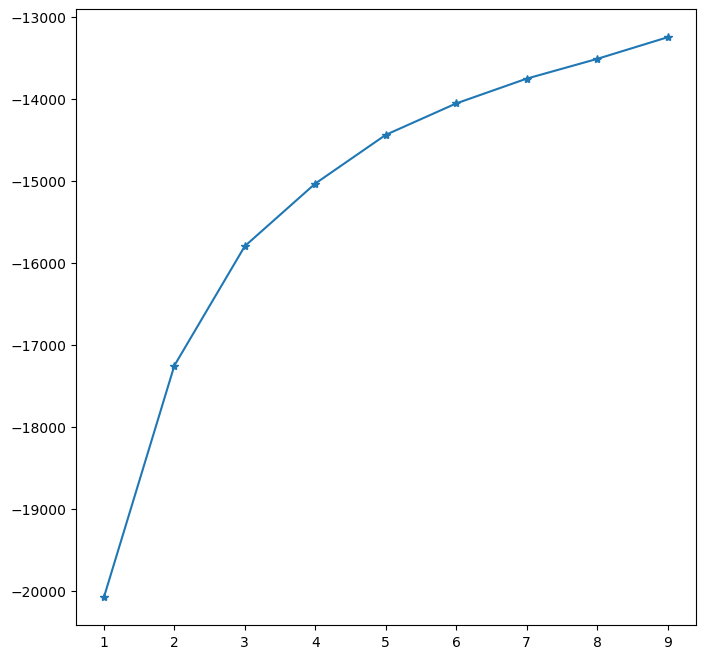

In [65]:
plt.figure(figsize=(8, 8))
plt.plot(range(1, 10), ssd, "-*")
plt.show()

In [66]:
ssd = np.array(ssd)
(ssd[:-1] - ssd[1:]) * 100 / ssd[:-1]

array([14.07999905,  8.45199979,  4.83483603,  3.9547533 ,  2.6561922 ,
        2.15176214,  1.75212757,  1.95480344])

In [67]:
clusters = KMeans(n_clusters=3, random_state=42).fit_predict(data_dtm)

In [68]:
silhouette_val = silhouette_samples(data_dtm, clusters)
sil_df = pd.DataFrame()
sil_df['cluster'] = clusters
sil_df['score'] = silhouette_val

In [69]:
error = sil_df[sil_df['score'] < 0]
error

,cluster,score
88,1,-0.007360
139,1,-0.000154
203,2,-0.003177
217,1,-0.001700
378,1,-0.002074
432,1,-0.000754
458,1,-0.002483
576,1,-0.006038
743,1,-0.000431
758,1,-0.003249


In [70]:
np.sqrt(np.mean(np.square(0 - error['score'])))

0.004385281124418653

In [71]:
df['class'] = clusters

In [72]:
import seaborn as sns

In [73]:
dfc1 = df[df['class'] == 0]
dfc2 = df[df['class'] == 1]
dfc3 = df[df['class'] == 2]

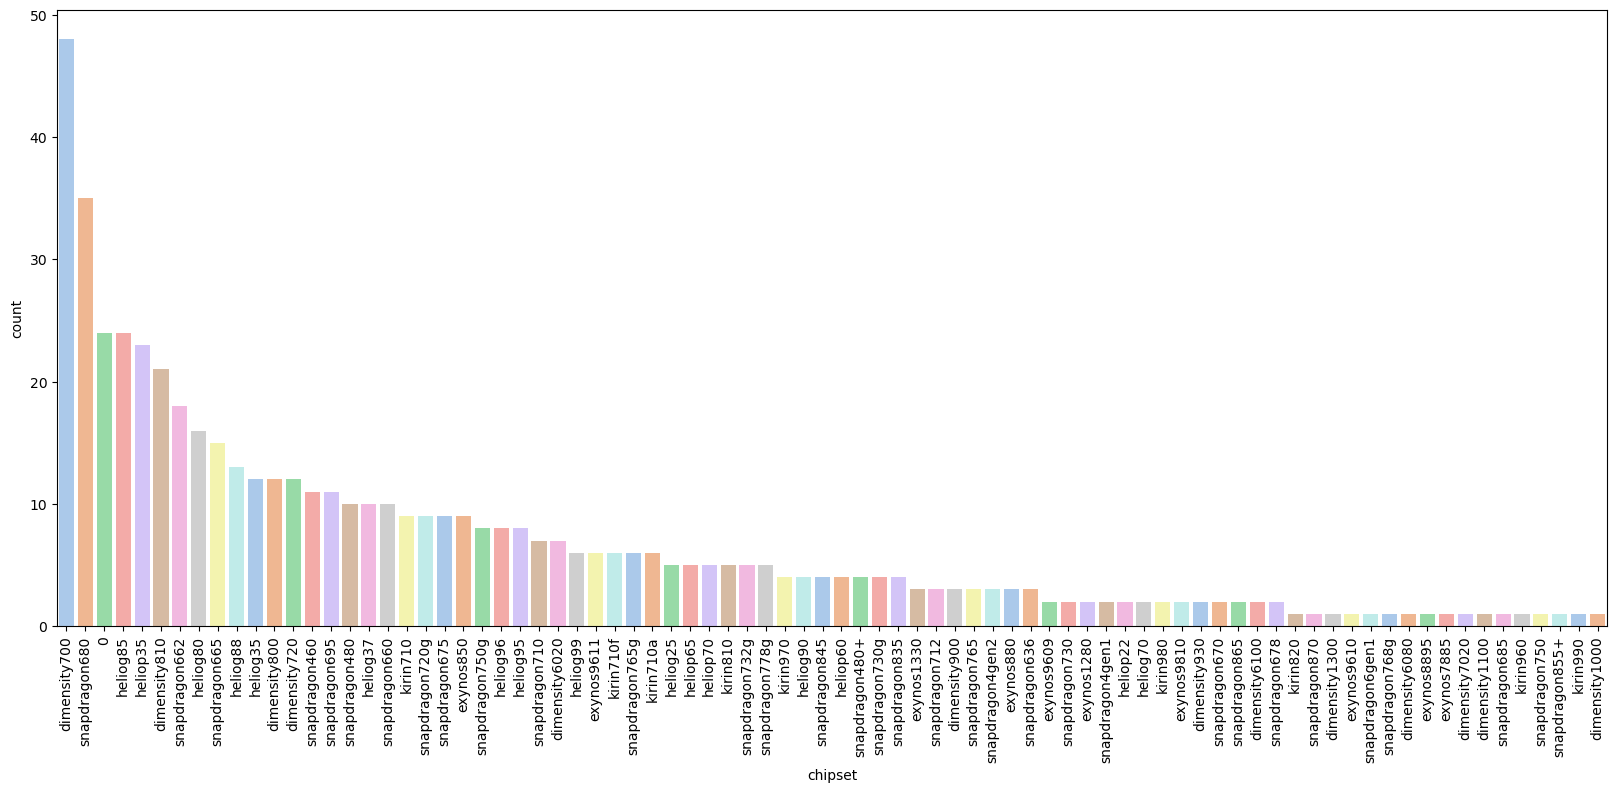

In [74]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc1['chipset'].value_counts(), palette='pastel')
plt.xticks(rotation=90)
plt.show()

- Analysis
  - The phones in class 0 are all the old phones or the phones with very less information to know about.
  - Most of the chipset in this class belong to old generation before 2018 or even older.


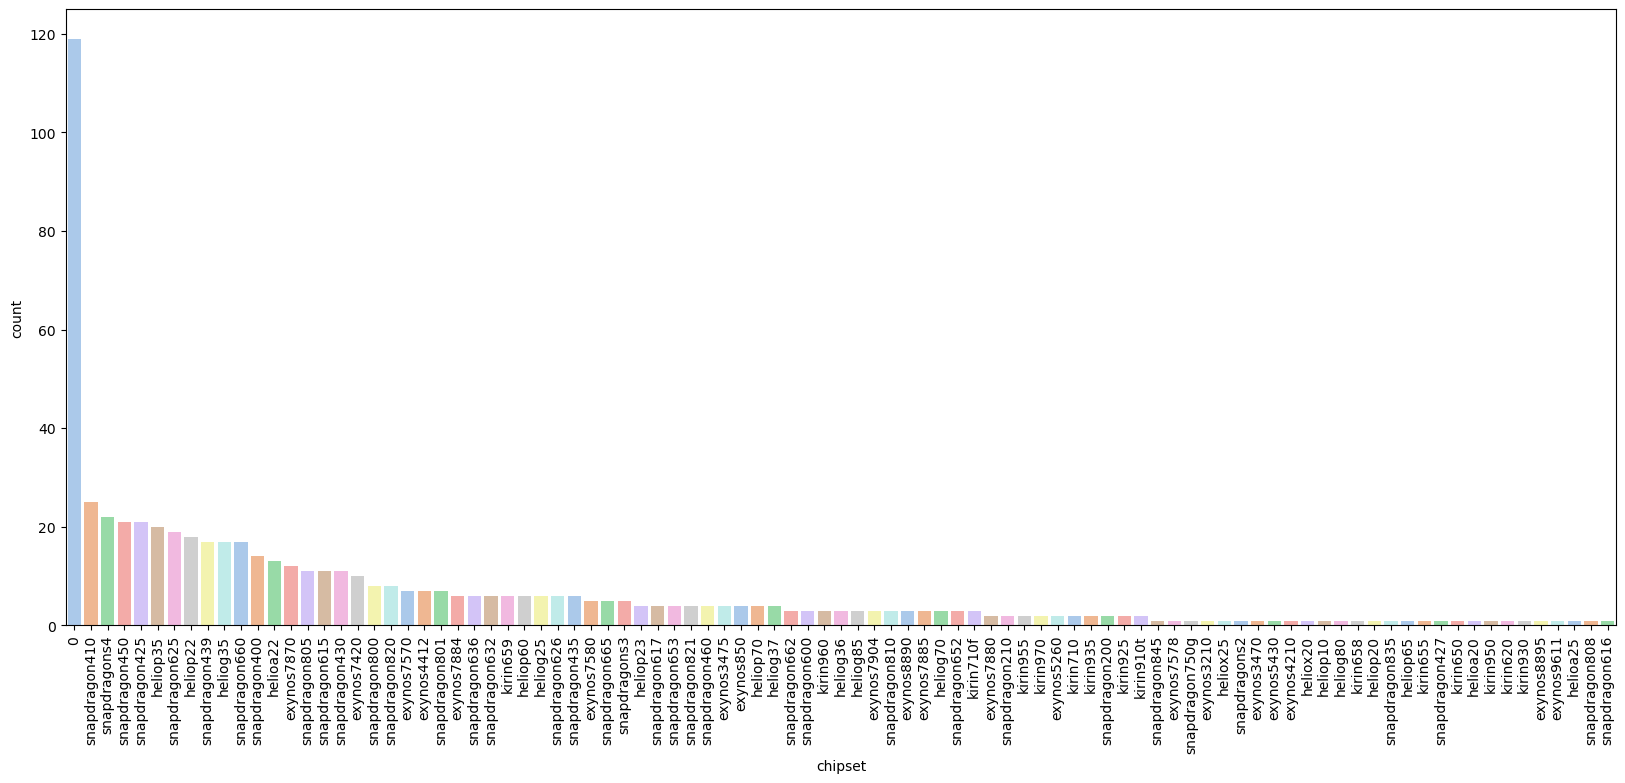

In [75]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc2['chipset'].value_counts(), palette='pastel')
plt.xticks(rotation=90)
plt.show()

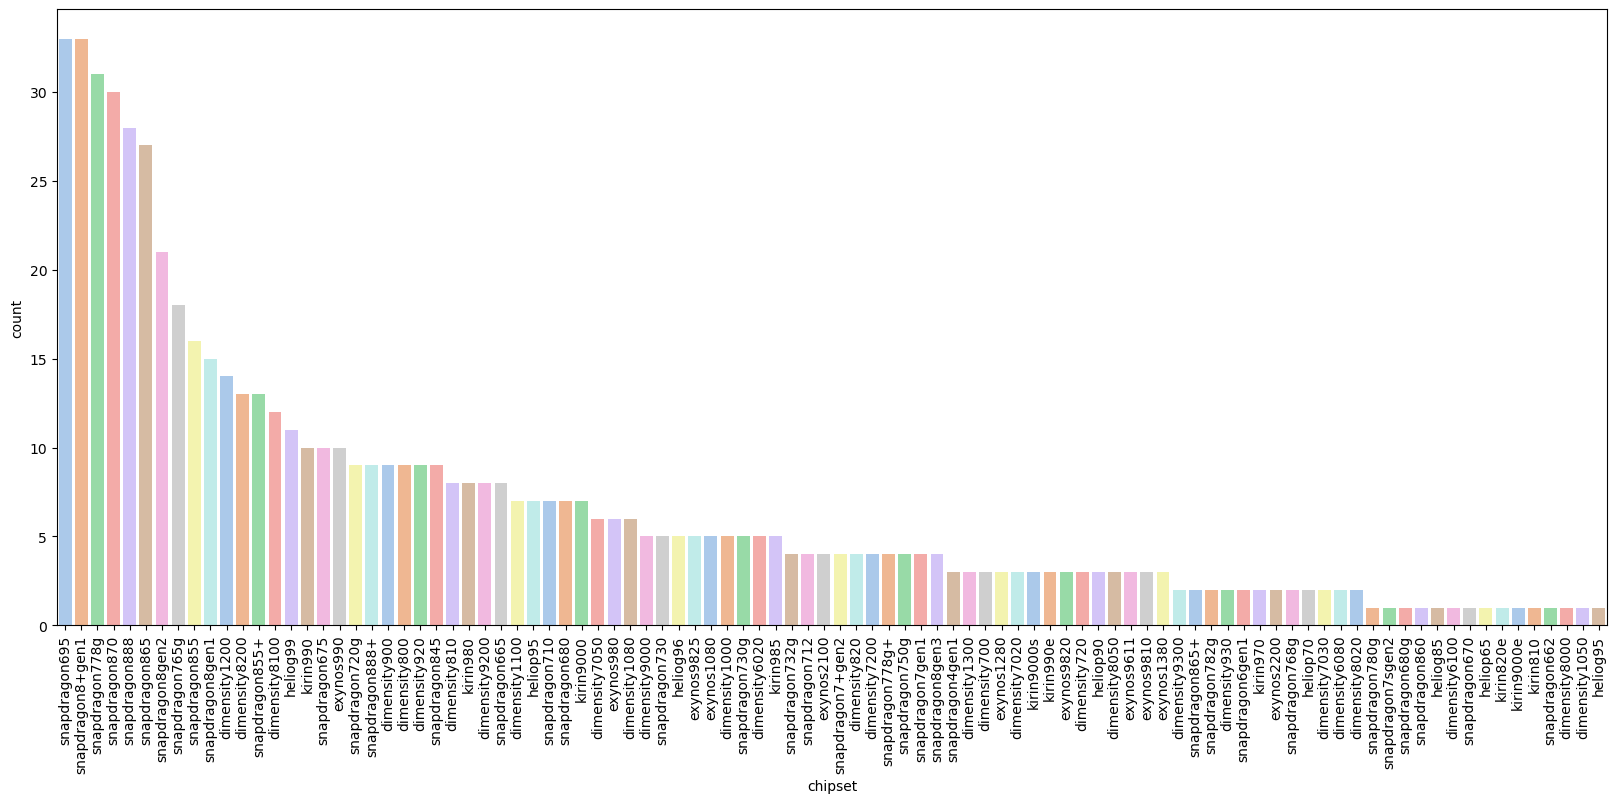

In [76]:
plt.figure(figsize=(20, 8))
sns.barplot(data=dfc3['chipset'].value_counts(), palette="pastel")
plt.xticks(rotation=90)
plt.show()

In [78]:
specs_text = list(df1['new_text'])

In [79]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Initialize the Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(specs_text)

# Convert text to sequences of integers
sequences = tokenizer.texts_to_sequences(specs_text)

# Pad sequences to make them of equal length (required for neural networks)
max_sequence_length = max(map(len, sequences))
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

# Vocabulary size
vocabulary_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [80]:
X = pd.DataFrame(padded_sequences)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,49,46,1,4,31,11,39,254,2,81,...,0,0,0,0,0,0,0,0,0,0
1,49,46,1,16,4,57,101,11,27,254,...,0,0,0,0,0,0,0,0,0,0
2,49,46,1,16,31,57,11,27,254,2,...,8,388,0,0,0,0,0,0,0,0
3,49,46,1,16,4,57,101,11,27,254,...,18,0,0,0,0,0,0,0,0,0
4,49,46,1,31,2,12,9,39,291,81,...,0,0,0,0,0,0,0,0,0,0


In [82]:
y = to_categorical(clusters)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1
output_classes = 3

In [85]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=X.shape[1]))
model.add(LSTM(100))
model.add(Dense(output_classes, activation='softmax'))

In [86]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            25900     
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 3)                 303       
                                                                 
Total params: 86603 (338.29 KB)
Trainable params: 86603 (338.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [87]:
# Train the model
epochs = 25
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/20


37/37 [==============================] - 3s 28ms/step - loss: 0.9096 - accuracy: 0.5112 - val_loss: 0.5367 - val_accuracy: 0.7113
Epoch 2/20
37/37 [==============================] - 0s 13ms/step - loss: 0.5044 - accuracy: 0.7208 - val_loss: 0.3849 - val_accuracy: 0.8591
Epoch 3/20
37/37 [==============================] - 0s 13ms/step - loss: 0.2719 - accuracy: 0.8918 - val_loss: 0.2461 - val_accuracy: 0.9107
Epoch 4/20
37/37 [==============================] - 1s 14ms/step - loss: 0.1288 - accuracy: 0.9570 - val_loss: 0.1200 - val_accuracy: 0.9553
Epoch 5/20
37/37 [==============================] - 0s 14ms/step - loss: 0.0700 - accuracy: 0.9777 - val_loss: 0.2584 - val_accuracy: 0.9210
Epoch 6/20
37/37 [==============================] - 0s 13ms/step - loss: 0.0499 - accuracy: 0.9854 - val_loss: 0.0928 - val_accuracy: 0.9588
Epoch 7/20
37/37 [==============================] - 0s 13ms/step - loss: 0.0576 - accuracy: 0.9811 - val_loss: 0.1089 - val_accuracy: 0.9588
Epoch 8/20


In [88]:
accuracy = model.evaluate(X_test, y_test)[1]
print(f'\nTest Accuracy: {accuracy * 100:.2f}%')

12/12 [==============================] - 0s 6ms/step - loss: 0.0970 - accuracy: 0.9780

Test Accuracy: 97.80%


In [89]:
input_user = "huawei lte 5g 1 1 163.7 79 8.1 225 1260 2720 440 6.8 oled 120hz android12.0 snapdragon888+ 8gbram 128gb 12mp bluetooth5.0 4500mah"

In [90]:
user_in = tokenizer.texts_to_sequences([input_user])

In [91]:
user_in = pad_sequences(user_in, maxlen=max_sequence_length, padding="post")

In [92]:
user_in

array([[ 49,   1,  16,   3,   3,  31,  57,   3,   4,  57,  11,  27,  44,
          2,  83,   5, 112,   7,   2,  55,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [93]:
pred = model.predict(user_in)
pred

1/1 [==============================] - 0s 476ms/step


array([[7.0332602e-04, 3.7308193e-05, 9.9925941e-01]], dtype=float32)

In [101]:
p = np.argmax(pred, axis=1)
p[0]

2

In [103]:
user_cv_data = cv.transform([input_user])
user_cv_data

<1x500 sparse matrix of type '<class 'numpy.int64'>'
	with 11 stored elements in Compressed Sparse Row format>

In [104]:
from sklearn.metrics.pairwise import cosine_similarity

In [117]:
pd.DataFrame(cosine_similarity(data_cv, user_cv_data)).sort_values(0, ascending=False).head().index

Index([1641, 1192, 1556, 1705, 795], dtype='int64')